In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import pydicom
import matplotlib.pyplot as plt
import pylab
import cv2
from tensorflow.keras.utils import Sequence
#import gdcm
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
import tensorflow.keras.regularizers as R
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [2]:
EPOCHS = 5
NUM_IMAGES = 150
BATCH_SIZE = 5
FOLDS = 5
IMAGE_DIM = (NUM_IMAGES,55,55)
COMP_DIR = '../input/osic-pulmonary-fibrosis-progression/'
TRAIN_PATH = '../input/osic-pulmonary-fibrosis-progression/train'
TEST_PATH = '../input/osic-pulmonary-fibrosis-progression/test'
SUB_PATH = '../input/osic-pulmonary-fibrosis-progression/sample_submission.csv'

In [3]:
comp_dir = '../input/osic-pulmonary-fibrosis-progression'

train_data = pd.read_csv(os.path.join(comp_dir,'train.csv'))
sub = pd.read_csv(os.path.join(comp_dir,'sample_submission.csv'))
test_data = pd.read_csv(os.path.join(comp_dir,'test.csv'))
train_data.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])

In [4]:
train_data_u = train_data
train_data_u = train_data_u.drop_duplicates(subset=['Patient'])
train_data_u = train_data_u.rename(columns={'Weeks':'Base_Week','FVC':'Base_FVC','Percent':'Base_Percent'})
train_data_u['Typical_FVC'] = (train_data_u.Base_FVC.values/train_data_u.Base_Percent.values)*100
train_data = train_data.merge(train_data_u.drop(['Age','Sex','SmokingStatus'],axis=1),on='Patient',how='left')

In [5]:
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub = sub.drop(['Confidence'],axis=1)
sub =  sub[['Patient','Weeks','Patient_Week']]

In [6]:
test_data = test_data.rename(columns={'Weeks':'Base_Week','FVC':'Base_FVC','Percent':'Base_Percent'})
test_data['Typical_FVC'] = (test_data.Base_FVC.values/test_data.Base_Percent.values)*100
sub = sub.merge(test_data, how='left', on='Patient')

In [7]:
train_data['Type'] = 'train'
sub['Type'] = 'test'

In [8]:
data = train_data.append(sub)

In [9]:
data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Base_Week,Base_FVC,Base_Percent,Typical_FVC,Type,Patient_Week
0,ID00007637202177411956430,-4,2315.0,58.253649,79,Male,Ex-smoker,-4,2315,58.253649,3974.0,train,NaN
1,ID00007637202177411956430,5,2214.0,55.712129,79,Male,Ex-smoker,-4,2315,58.253649,3974.0,train,NaN
2,ID00007637202177411956430,7,2061.0,51.862104,79,Male,Ex-smoker,-4,2315,58.253649,3974.0,train,NaN
3,ID00007637202177411956430,9,2144.0,53.950679,79,Male,Ex-smoker,-4,2315,58.253649,3974.0,train,NaN
4,ID00007637202177411956430,11,2069.0,52.063412,79,Male,Ex-smoker,-4,2315,58.253649,3974.0,train,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,ID00419637202311204720264,133,NaN,NaN,73,Male,Ex-smoker,6,3020,70.186855,4302.8,test,ID00419637202311204720264_133
726,ID00421637202311550012437,133,NaN,NaN,68,Male,Ex-smoker,15,2739,82.045291,3338.4,test,ID00421637202311550012437_133
727,ID00422637202311677017371,133,NaN,NaN,73,Male,Ex-smoker,6,1930,76.672493,2517.2,test,ID00422637202311677017371_133
728,ID00423637202312137826377,133,NaN,NaN,72,Male,Ex-smoker,17,3294,79.258903,4156.0,test,ID00423637202312137826377_133


In [10]:
prediction_col = ["FVC"]
Continuos_cols = ["Weeks","Base_Week","Base_FVC","Typical_FVC","Age","Percent","Base_Percent"]
Categorical_cols = ['Sex','Smoking_status']

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()
conti = scaler.fit_transform(data[Continuos_cols])
data[Continuos_cols] = conti

In [13]:
print(np.mean(train_data_u.query('SmokingStatus == \'Never smoked\'').Base_Percent.values))
print(np.mean(train_data_u.query('SmokingStatus == \'Currently smokes\'').Base_Percent.values))
print(np.mean(train_data_u.query('SmokingStatus == \'Ex-smoker\'').Base_Percent.values))
print(np.mean(train_data_u.query('Sex == \'Male\'').Base_Percent.values))
print(np.mean(train_data_u.query('Sex == \'Female\'').Base_Percent.values))

79.50710799558858
98.51592571905941
79.08661822268049
78.86695444921291
85.19475419165079


In [14]:
sex_m = np.zeros((len(data['Sex'].values),1))
sex_f = np.zeros((len(data['Sex'].values),1))
sm_es = np.zeros((len(data['Sex'].values),1))
sm_ns = np.zeros((len(data['Sex'].values),1))
sm_cs = np.zeros((len(data['Sex'].values),1))
for i in range(len(data['Sex'].values)):
    if data['Sex'].values[i] == 'Male':
        sex_m[i] = 1
    elif data['Sex'].values[i] == 'Female':
        sex_f[i] = 1
for i in range(len(data['SmokingStatus'].values)):
    if data['SmokingStatus'].values[i] =='Ex-smoker':
        sm_es[i] = 1
    elif data['SmokingStatus'].values[i] =='Never smoked':
        sm_ns[i] = 1
    else:
        sm_cs[i] = 1

data['sex_m'] = sex_m
data['sex_f'] = sex_f
data['sm_es'] = sm_es
data['sm_ns'] = sm_ns
data['sm_cs'] = sm_cs


for i in range(len(data['Sex'].values)):
    if data['Sex'].values[i] =='Male':
        data['Sex'].values[i] = 0
    else:
        data['Sex'].values[i] = 1

for i in range(len(data['SmokingStatus'].values)):
    if data['SmokingStatus'].values[i] =='Ex-smoker':
        data['SmokingStatus'].values[i] = 0
    elif data['SmokingStatus'].values[i] =='Never smoked':
        data['SmokingStatus'].values[i] = 1     
    else:
        data['SmokingStatus'].values[i] = 2 

In [15]:
data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Base_Week,Base_FVC,Base_Percent,Typical_FVC,Type,Patient_Week,sex_m,sex_f,sm_es,sm_ns,sm_cs
0,ID00007637202177411956430,0.055172,2315.0,0.236393,0.769231,Male,Ex-smoker,0.011905,0.241456,0.135886,0.714466,train,NaN,1.0,0.0,1.0,0.0,0.0
1,ID00007637202177411956430,0.117241,2214.0,0.215941,0.769231,Male,Ex-smoker,0.011905,0.241456,0.135886,0.714466,train,NaN,1.0,0.0,1.0,0.0,0.0
2,ID00007637202177411956430,0.131034,2061.0,0.184960,0.769231,Male,Ex-smoker,0.011905,0.241456,0.135886,0.714466,train,NaN,1.0,0.0,1.0,0.0,0.0
3,ID00007637202177411956430,0.144828,2144.0,0.201767,0.769231,Male,Ex-smoker,0.011905,0.241456,0.135886,0.714466,train,NaN,1.0,0.0,1.0,0.0,0.0
4,ID00007637202177411956430,0.158621,2069.0,0.186580,0.769231,Male,Ex-smoker,0.011905,0.241456,0.135886,0.714466,train,NaN,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,ID00419637202311204720264,1.000000,NaN,NaN,0.615385,Male,Ex-smoker,0.130952,0.372400,0.244706,0.813374,test,ID00419637202311204720264_133,1.0,0.0,1.0,0.0,0.0
726,ID00421637202311550012437,1.000000,NaN,NaN,0.487179,Male,Ex-smoker,0.238095,0.320208,0.352843,0.523268,test,ID00421637202311550012437_133,1.0,0.0,1.0,0.0,0.0
727,ID00422637202311677017371,1.000000,NaN,NaN,0.615385,Male,Ex-smoker,0.130952,0.169948,0.303848,0.276239,test,ID00422637202311677017371_133,1.0,0.0,1.0,0.0,0.0
728,ID00423637202312137826377,1.000000,NaN,NaN,0.589744,Male,Ex-smoker,0.261905,0.423291,0.327434,0.769215,test,ID00423637202312137826377_133,1.0,0.0,1.0,0.0,0.0


In [16]:
x_cols = ['Weeks','Base_Week','Base_FVC','Age','sex_m','sex_f','sm_es','sm_ns','sm_cs']

In [17]:
x_train = data[x_cols].loc[data['Type'] == "train"].values.astype(np.float)
y_train = data[prediction_col].loc[data['Type'] == "train"].values.astype(np.float)
x_test = data[x_cols].loc[data['Type'] == "test"].values.astype(np.float)

In [18]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [19]:
x_train.shape,y_train.shape,x_test.shape

((1535, 9), (1535, 1), (730, 9))

In [20]:
type(x_train[0][3])

numpy.float32

In [21]:
type(x_train),type(y_train),type(x_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [22]:
data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Base_Week,Base_FVC,Base_Percent,Typical_FVC,Type,Patient_Week,sex_m,sex_f,sm_es,sm_ns,sm_cs
0,ID00007637202177411956430,0.055172,2315.0,0.236393,0.769231,Male,Ex-smoker,0.011905,0.241456,0.135886,0.714466,train,NaN,1.0,0.0,1.0,0.0,0.0
1,ID00007637202177411956430,0.117241,2214.0,0.215941,0.769231,Male,Ex-smoker,0.011905,0.241456,0.135886,0.714466,train,NaN,1.0,0.0,1.0,0.0,0.0
2,ID00007637202177411956430,0.131034,2061.0,0.184960,0.769231,Male,Ex-smoker,0.011905,0.241456,0.135886,0.714466,train,NaN,1.0,0.0,1.0,0.0,0.0
3,ID00007637202177411956430,0.144828,2144.0,0.201767,0.769231,Male,Ex-smoker,0.011905,0.241456,0.135886,0.714466,train,NaN,1.0,0.0,1.0,0.0,0.0
4,ID00007637202177411956430,0.158621,2069.0,0.186580,0.769231,Male,Ex-smoker,0.011905,0.241456,0.135886,0.714466,train,NaN,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,ID00419637202311204720264,1.000000,NaN,NaN,0.615385,Male,Ex-smoker,0.130952,0.372400,0.244706,0.813374,test,ID00419637202311204720264_133,1.0,0.0,1.0,0.0,0.0
726,ID00421637202311550012437,1.000000,NaN,NaN,0.487179,Male,Ex-smoker,0.238095,0.320208,0.352843,0.523268,test,ID00421637202311550012437_133,1.0,0.0,1.0,0.0,0.0
727,ID00422637202311677017371,1.000000,NaN,NaN,0.615385,Male,Ex-smoker,0.130952,0.169948,0.303848,0.276239,test,ID00422637202311677017371_133,1.0,0.0,1.0,0.0,0.0
728,ID00423637202312137826377,1.000000,NaN,NaN,0.589744,Male,Ex-smoker,0.261905,0.423291,0.327434,0.769215,test,ID00423637202312137826377_133,1.0,0.0,1.0,0.0,0.0


In [23]:
class Data_Generator(tf.keras.utils.Sequence):
    
    def __init__(self,batch_size,patient_ids,tab_data,dim,target=None,train=True,augment=False):
        self.batch_size = batch_size
        self.image_ids = patient_ids
        self.augment = augment
        self.dim = dim
        self.target = target
        self.indices = range(len(self.image_ids))
        self.train = train
        self.tab_data = tab_data
        #self.on_epoch_end()
    
    def getimage(self,image_id):
        X1 = np.zeros((NUM_IMAGES,self.dim[1],self.dim[2], 1))
        if self.train:
            path = TRAIN_PATH
        else:
            path = TEST_PATH
        im_num = len(os.listdir(os.path.join(path,image_id)))
        if im_num < NUM_IMAGES+1:
            for i,dcm_i in enumerate(os.listdir(os.path.join(path,image_id))):
                try:
                    im = pydicom.dcmread(os.path.join(TRAIN_PATH,f'{image_id}/{dcm_i}'))
                    img = im.pixel_array/255
                    img = cv2.resize(img, (self.dim[1],self.dim[2]))
                    img = np.reshape(img,(IMAGE_DIM[1],IMAGE_DIM[2],1))
                    X1[i,] = img
                    if i>=NUM_IMAGES-1:
                        break
                except:
                    continue
        else:
            val = (im_num - NUM_IMAGES)//2
            dir_list = os.listdir(os.path.join(path,image_id))
            dir_list.sort()
            for i,dcm_i in enumerate(dir_list[val:]):
                try:
                    im = pydicom.dcmread(os.path.join(TRAIN_PATH,f'{image_id}/{dcm_i}'))
                    img = im.pixel_array/255
                    img = cv2.resize(img, (self.dim[1],self.dim[2]))
                    img = np.reshape(img,(IMAGE_DIM[1],IMAGE_DIM[2],1))
                    X1[i,] = img
                    if i>=NUM_IMAGES-1:
                        break
                except:
                    continue
               
        if self.augment == True:
            img = self.ImageAugment(img)
            return img
        return X1
    
    def on_epoch_end(self):
        return self.indices
    
    def getdata(self, image_id_list):
        X = np.empty((self.batch_size,*self.dim, 1))
        for i, im_id in enumerate(image_id_list):
            #print(i)
            X[i,] = self.getimage(im_id)
        
        return X
    '''
    def ImageAugment(self,image):
        augmentor = ImageAugmentor(image,axis_point=[self.dim/2,self.dim/2])
        augmentor.cutmix()
        #augmentor.zoom()
        augmentor.flip()
        augmentor.rotate()
        return augmentor.get_image()
    ''' 
    
    def __getitem__(self,index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        image_id_list = [self.image_ids[k] for k in indices]
        tab_X = np.array([self.tab_data[k] for k in indices]).astype(np.float32)
        X = self.getdata(image_id_list)
        if self.train == True:
            target_list = [self.target[k] for k in indices]
            y = np.array(target_list).astype(np.float32)
            return X,y
        return X
    
    def __len__(self):
        return int(np.floor(len(self.indices)/self.batch_size))
    

In [24]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:,2]-y_pred[:,0]
    fvc_pred = y_pred[:,1]
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:,0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2,0.50,0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e,(q-1)*e)
    return K.mean(v)
#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss
#=================

In [25]:
def build_model_dense():
    
    inp = L.Input((9,))
    x = L.Dense(128,activation ='relu',kernel_regularizer=R.l2(5e-4),name='dense')(inp)
    x = L.Dense(128,activation ='relu',kernel_regularizer=R.l2(5e-4),name='dense_1')(x)
    x = L.Dense(64,activation ='relu',kernel_regularizer=R.l2(5e-5),name='dense_2')(x)
    o1 = L.Dense(3,activation = 'linear',name='dense_3')(x)
    o2 = L.Dense(3,activation = 'relu',name='dense_4')(x)
    pred1 = L.Lambda(lambda x: (x[0]+(tf.cumsum(x[1],axis=1))))([o1,o2])    
    
    
    model = M.Model(inputs=inp,outputs=pred1)
    
    model.compile(loss=mloss(0.85), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=[score])
    
    return model

In [26]:
dense_model = build_model_dense()
dense_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1280        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

In [27]:
from sklearn.model_selection import KFold
folds = 5
KF = KFold(n_splits=folds,shuffle=True,random_state=24)

In [28]:
%%time
counter=0
stopper = tf.keras.callbacks.EarlyStopping(monitor='loss',mode='min',patience=100,restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,patience=50, min_lr=1e-3)
for tr_idx, val_idx in KF.split(x_train):
    counter+=1
    print(f'############## FOLD {counter} ###############')
    history = dense_model.fit(x_train[tr_idx],y_train[tr_idx],epochs=500,batch_size = 256,verbose=0,validation_data=(x_train[val_idx],y_train[val_idx]))
    print("train", dense_model.evaluate(x_train[tr_idx], y_train[tr_idx], verbose=0, batch_size=256))
    print("val", dense_model.evaluate(x_train[val_idx], y_train[val_idx], verbose=0, batch_size=256))

############## FOLD 1 ###############
train [49.614013671875, 6.590298652648926]
val [60.742855072021484, 6.738798141479492]
############## FOLD 2 ###############
train [50.720333099365234, 6.607256889343262]
val [53.111480712890625, 6.705302715301514]
############## FOLD 3 ###############
train [50.50727081298828, 6.58261251449585]
val [47.63249588012695, 6.572506904602051]
############## FOLD 4 ###############
train [50.502010345458984, 6.597799777984619]
val [50.683353424072266, 6.612125873565674]
############## FOLD 5 ###############
train [50.08330535888672, 6.582428932189941]
val [45.92015838623047, 6.50098991394043]
CPU times: user 1min 46s, sys: 6.08 s, total: 1min 52s
Wall time: 1min 41s


In [29]:
dense_model.save('dense_model.h5')
dense_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1280        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

In [30]:
def build_model():
        
    inp2 = L.Input(shape=(*IMAGE_DIM,1,),name='conv_input')
    
    x = L.Conv3D(64,5,activation='relu')(inp2)
    
    x = L.Conv3D(64,5,activation='relu')(x)
    
    x = L.BatchNormalization()(x)
    
    x = L.MaxPooling3D()(x)
    
    x1 = L.Dropout(0.3)(x)
    
    x = L.Conv3D(64,7,activation='relu',padding='same')(x1)
    
    x = L.Dropout(0.3)(x)
    
    x = L.add([x,x1])
    
    x = L.Conv3D(256,7,activation='relu')(x)
    
    x = L.Conv3D(128,9,activation='relu')(x)
    
    x = L.BatchNormalization()(x)
    
    x = L.MaxPooling3D()(x)
    
    x2 = L.Dropout(0.43)(x)
    
    x = L.Conv3D(128,7,activation='relu',padding='same',data_format='channels_last')(x2)
    
    x = L.Dropout(0.43)(x)
    
    x = L.add([x,x2])
    
    x = L.BatchNormalization()(x)
    
    x = L.MaxPooling3D()(x)
    
    x = L.Dropout(0.43)(x)
    
    op1 = L.GlobalAveragePooling3D()(x)
    '''
    tab_model = M.load_model('dense_model.h5',custom_objects={'loss':mloss,'score':score})
    
    tab_model.trainable = False
    
    inp = L.Input((9,),name='input_d')

    d = tab_model.get_layer(name='dense')(inp)
    
    d1 = tab_model.get_layer(name='dense_1')(d)
    
    op2 = tab_model.get_layer(name='dense_2')(d1)    
    
    inp = L.Input(shape=(4,),name='tab_input')
    
    x = L.Dense(128,activation ='relu',kernel_regularizer=R.l2(5e-4))(inp)
    
    x = L.Dense(128,activation ='relu',kernel_regularizer=R.l2(4e-4))(x)
    
    op2 = L.Dense(64,activation ='relu',kernel_regularizer=R.l2(2e-5))(x)
 
    x = L.add([op1,op2])
    '''
    o1 = L.Dense(3,activation = 'linear',name = 'dense_f1')(op1)
    o2 = L.Dense(3,activation = 'relu', name='dense_f2')(op1)
    
    pred1 = L.Lambda(lambda x: (x[0]+(tf.cumsum(x[1],axis=1))),name='output')([o1,o2])    
    
    
    model = M.Model(inputs=inp2,outputs=pred1)
    
    model.compile(loss=mloss(0.9), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=[score])
    
    return model


In [31]:
model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv_input (InputLayer)         [(None, 150, 55, 55, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 146, 51, 51,  8064        conv_input[0][0]                 
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 142, 47, 47,  512064      conv3d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 142, 47, 47,  256         conv3d_1[0][0]                   
____________________________________________________________________________________________

In [32]:
folds = 5
KF = KFold(n_splits=folds,shuffle=True,random_state=24)

In [33]:
x_train = data[x_cols].loc[data['Type'] == "train"].values
y_train = data[prediction_col].loc[data['Type'] == "train"].values
x_test = data[x_cols].loc[data['Type'] == "test"].values

In [34]:
def get_lr_callback():
    lr_start   = 0.001
    lr_max     = 0.001
    lr_min     = 0.00001
    lr_ramp_ep = EPOCHS
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = lr_start - ( lr_start - lr_min ) / lr_ramp_ep * epoch 
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_min
            '''
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            '''
        return lr
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [35]:
#tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)


################ FOLD 1 #####################
Epoch 1/5
245/245 [==============================] - 559s 2s/step - loss: 1166.7080 - score: 20.1785 - val_loss: 948.1885 - val_score: 11.5759 - lr: 0.0010
Epoch 2/5
245/245 [==============================] - 524s 2s/step - loss: 1018.8956 - score: 10.3732 - val_loss: 1011.6602 - val_score: 9.9891 - lr: 8.0200e-04
Epoch 3/5
245/245 [==============================] - 609s 2s/step - loss: 841.1771 - score: 8.9081 - val_loss: 911.5977 - val_score: 9.1505 - lr: 6.0400e-04
Epoch 4/5
245/245 [==============================] - 520s 2s/step - loss: 692.7885 - score: 8.5907 - val_loss: 737.2781 - val_score: 8.7155 - lr: 4.0600e-04
Epoch 5/5
245/245 [==============================] - 519s 2s/step - loss: 602.4833 - score: 8.4959 - val_loss: 735.6852 - val_score: 8.6762 - lr: 2.0800e-04


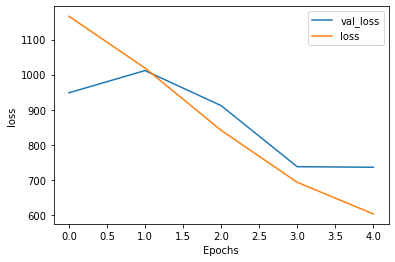

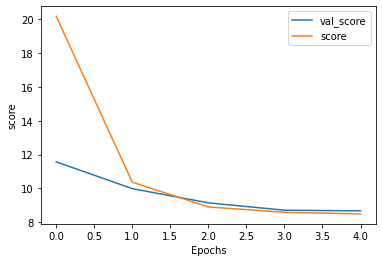

################ FOLD 2 #####################
Epoch 1/5
245/245 [==============================] - 516s 2s/step - loss: 472.9183 - score: 8.4117 - val_loss: 536.2432 - val_score: 8.5345 - lr: 0.0010
Epoch 2/5
245/245 [==============================] - 520s 2s/step - loss: 330.7811 - score: 8.3430 - val_loss: 408.4733 - val_score: 8.3277 - lr: 8.0200e-04
Epoch 3/5
245/245 [==============================] - 514s 2s/step - loss: 277.8158 - score: 8.3048 - val_loss: 408.0590 - val_score: 8.3440 - lr: 6.0400e-04
Epoch 4/5
245/245 [==============================] - 518s 2s/step - loss: 260.2892 - score: 8.2863 - val_loss: 365.5012 - val_score: 8.2974 - lr: 4.0600e-04
Epoch 5/5
245/245 [==============================] - 517s 2s/step - loss: 251.2464 - score: 8.2705 - val_loss: 383.8422 - val_score: 8.2736 - lr: 2.0800e-04


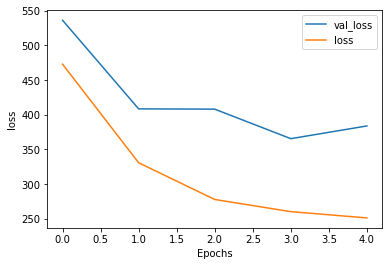

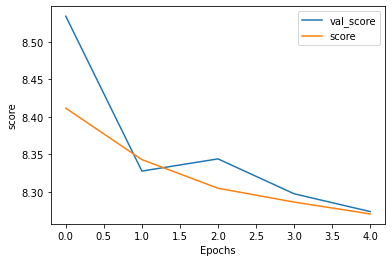

################ FOLD 3 #####################
Epoch 1/5
245/245 [==============================] - 522s 2s/step - loss: 260.9011 - score: 8.2787 - val_loss: 367.7435 - val_score: 8.2881 - lr: 0.0010
Epoch 2/5
245/245 [==============================] - 516s 2s/step - loss: 246.2446 - score: 8.2467 - val_loss: 411.2628 - val_score: 8.3240 - lr: 8.0200e-04
Epoch 3/5
245/245 [==============================] - 521s 2s/step - loss: 242.5289 - score: 8.2252 - val_loss: 377.0608 - val_score: 8.2633 - lr: 6.0400e-04
Epoch 4/5
245/245 [==============================] - 520s 2s/step - loss: 238.3906 - score: 8.2094 - val_loss: 373.3526 - val_score: 8.2544 - lr: 4.0600e-04
Epoch 5/5
245/245 [==============================] - 553s 2s/step - loss: 235.4248 - score: 8.2007 - val_loss: 416.8190 - val_score: 8.3179 - lr: 2.0800e-04


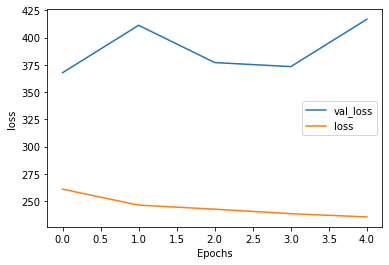

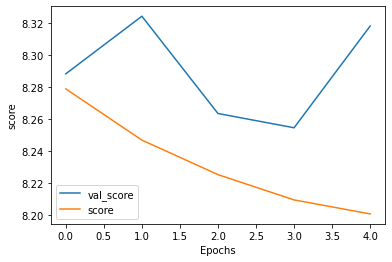

################ FOLD 4 #####################
Epoch 1/5
245/245 [==============================] - 519s 2s/step - loss: 236.5767 - score: 8.1879 - val_loss: 303.8884 - val_score: 8.2080 - lr: 0.0010
Epoch 2/5
245/245 [==============================] - 519s 2s/step - loss: 231.5584 - score: 8.1660 - val_loss: 356.2447 - val_score: 8.2321 - lr: 8.0200e-04
Epoch 3/5
245/245 [==============================] - 525s 2s/step - loss: 228.2530 - score: 8.1461 - val_loss: 403.7914 - val_score: 8.3023 - lr: 6.0400e-04
Epoch 4/5
245/245 [==============================] - 521s 2s/step - loss: 220.9574 - score: 8.1134 - val_loss: 390.9082 - val_score: 8.2889 - lr: 4.0600e-04
Epoch 5/5
245/245 [==============================] - 520s 2s/step - loss: 216.2569 - score: 8.0926 - val_loss: 395.1646 - val_score: 8.3084 - lr: 2.0800e-04


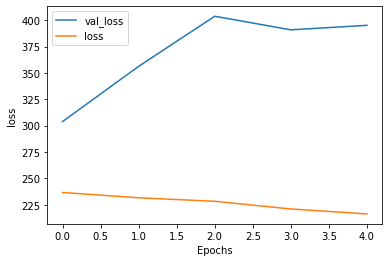

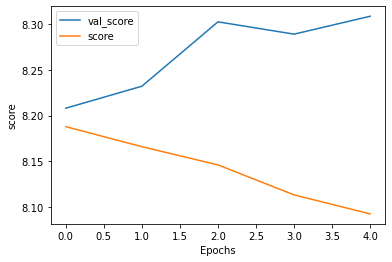

################ FOLD 5 #####################
Epoch 1/5
245/245 [==============================] - 524s 2s/step - loss: 230.6140 - score: 8.1334 - val_loss: 303.8429 - val_score: 8.1887 - lr: 0.0010
Epoch 2/5
245/245 [==============================] - 524s 2s/step - loss: 223.4686 - score: 8.1105 - val_loss: 455.0272 - val_score: 8.4655 - lr: 8.0200e-04
Epoch 3/5
245/245 [==============================] - 524s 2s/step - loss: 220.3052 - score: 8.0992 - val_loss: 412.2390 - val_score: 8.3594 - lr: 6.0400e-04
Epoch 4/5
245/245 [==============================] - 524s 2s/step - loss: 210.1551 - score: 8.0686 - val_loss: 473.8862 - val_score: 8.5090 - lr: 4.0600e-04
Epoch 5/5
245/245 [==============================] - 522s 2s/step - loss: 205.6506 - score: 8.0425 - val_loss: 356.8438 - val_score: 8.2501 - lr: 2.0800e-04


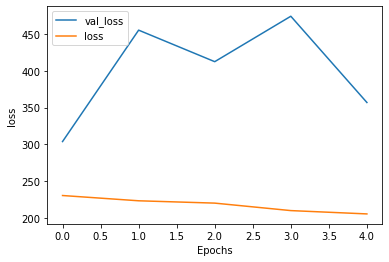

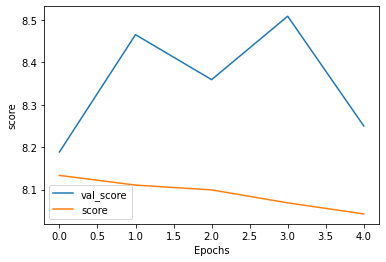

CPU times: user 3h 50min, sys: 1h 4min 53s, total: 4h 54min 53s
Wall time: 3h 41min


In [36]:
%%time
x_train = data[x_cols].loc[data['Type'] == "train"].values
patient_ids = data['Patient'].loc[data['Type']=='train'].values
target_val = data[prediction_col].loc[data['Type'] == "train"].values
for fold,(t_idx,v_idx) in enumerate(KF.split(patient_ids)):
    print(f"################ FOLD {fold+1} #####################")
    train_gen = Data_Generator(BATCH_SIZE,patient_ids[t_idx],x_train[t_idx],IMAGE_DIM,target=target_val[t_idx],train=True)
    val_gen = Data_Generator(BATCH_SIZE,patient_ids[v_idx],x_train[v_idx],IMAGE_DIM,target=target_val[v_idx],train=True)
    total_val_train = len(patient_ids[v_idx])
    total_train = len(patient_ids[t_idx])
    history = model.fit(
        train_gen,
        steps_per_epoch=total_train//BATCH_SIZE,
        epochs=EPOCHS,
        validation_data = val_gen,
        validation_steps = total_val_train//BATCH_SIZE,
        verbose=1,
        callbacks=[get_lr_callback()]
    )
    
    plt.figure()
    plt.plot(list(range(EPOCHS)),history.history['val_loss'])
    plt.plot(list(range(EPOCHS)),history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel('loss')
    plt.legend(['val_loss','loss'])
    plt.show()
    
    plt.figure()
    plt.plot(list(range(EPOCHS)),history.history['val_score'])
    plt.plot(list(range(EPOCHS)),history.history['score'])
    plt.xlabel("Epochs")
    plt.ylabel('score')
    plt.legend(['val_score','score'])
    plt.show()

In [37]:
model.save('model.h5')

In [38]:
#model = M.load_model('../input/tab-data-osic/model.h5',custom_objects={'loss':mloss,'score':score})
#model.summary()

In [39]:
#test_patient_ids = data['Patient'].loc[data['Type'] == "test"].values

In [40]:
#test_gen = Data_Generator(2,test_patient_ids,x_test,IMAGE_DIM,train=False)

In [41]:
#print("Inferencing")

In [42]:
#pred = model.predict(test_gen,verbose=1,batch_size=BATCH_SIZE)3

In [43]:
#pred

In [44]:
#conf = pred[:,2] - pred[:,0]
#for i in range(len(conf)):
#    conf[i] = max(conf[i],70)

In [45]:
#pred[:,1]

In [46]:
#pred_dict = {'FVC':pred[:,1],'Confidence':conf}
#pred_df = pd.DataFrame(pred_dict)

In [47]:
#sub['Confidence'] = pred_df['Confidence']
#sub['FVC'] = pred_df['FVC']

In [48]:
#subm = sub[['Patient_Week','FVC','Confidence']].copy()

In [49]:
#subm.to_csv("submission.csv", index=False)

import matplotlib.animation as animation
import matplotlib.pyplot as plt
for j in pat:
    fig = plt.figure()
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
    im=[]
    length = len([name for name in os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{j}')])
    try:
        for i in range(1,length+1):
            img_path = f'{comp_dir}/train/{j}/{i}.dcm'
            img = pydicom.dcmread(img_path)
            img = plt.imshow(img.pixel_array,cmap='gray')
            im.append([img])
        #im_ani = animation.FuncAnimation(fig, im, 25,interval=50, blit=True)
        im_ani = animation.ArtistAnimation(fig, im, interval=50,blit=True)
        im_ani.save(f'{j}.mp4', writer=writer)
    except:
        pass